___

<a href='https://github.com/eliasmelul/'> <img src='https://s3.us-east-2.amazonaws.com/wordontheamazon.com/NoMargin_NewLogo.png' style='width: 15em;' align='right' /></a>
# Finance with Python
### Monte Carlo Simulations with Cholesky Decomposition for Stock Price Predictions
___
<h4 align="right">by Elias Melul, Data Scientist </h4> 

___

A popular application of Monte Carlo Simulations is to predict stock prices. These simulations generate random standard normal values that are independent from one another. They're not corralated! 

However, when considering the returns of a portfolio, as CAPM and a number of other theories demonstrate, the correlation between stocks is very important. This becomes increasingly important in options pricing because the payoff of the derivative depends on a backet of underlying assets.

For example: you have Google and Facebook in your portfolio. They're both internet companies that earn most of their income through advertising. So when one goes up, you would expect the other one to go up as well! Hence, they are _somewhat_ correlated.
___

In this notebook, we discuss Cholesky Decomposition as a method to correlate the returns of all stocks included in the basket. To make the demonstration easier, we will do so with stock prices.


In [25]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy.stats import norm, gmean, cauchy
import seaborn as sns

%matplotlib inline

To show the relationship of the stock, we will use two common stocks that seem to be highly correlated.
1. Google (GOOG)
2. Facebook (FB)

In [27]:
def import_stock_data(tickers, start = '2010-1-1'):
    data = pd.DataFrame()
    if len([tickers]) ==1:
        data[tickers] = wb.DataReader(tickers, data_source='yahoo', start = start)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = wb.DataReader(t, data_source='yahoo', start = start)['Adj Close']
    return(data)

In [30]:
ticks = ['GOOG','FB']
num_stocks = len(ticks)
data = import_stock_data(ticks, start='2015-1-1')
data.head()

,GOOG,FB
Date,,
2015-01-02,523.373108,78.449997
2015-01-05,512.463013,77.190002
2015-01-06,500.585632,76.150002
2015-01-07,499.727997,76.150002
2015-01-08,501.303680,78.180000


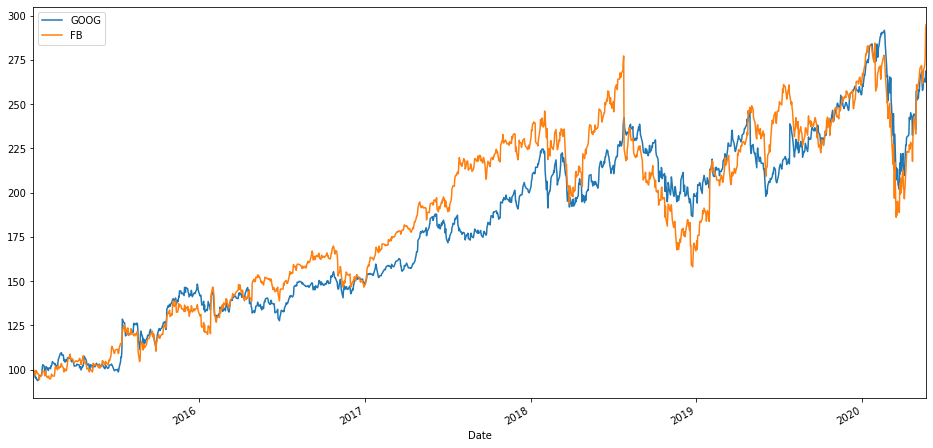

In [29]:
(data/data.iloc[0]*100).plot(figsize=(16,8))

Recall the two types of risks:
1. Systematic risk (undiversifiable) - the risk inherent to the entire market, sector or economy
2. Unsystematic (diversifiable) - the risk inherent to a specific company

In the above graph, we can observe that Google and Microsoft have overlapping industries and are prone to the same market fluctuations. When Microsoft goes up, so does Google, and viceversa. this is not common to all stocks!

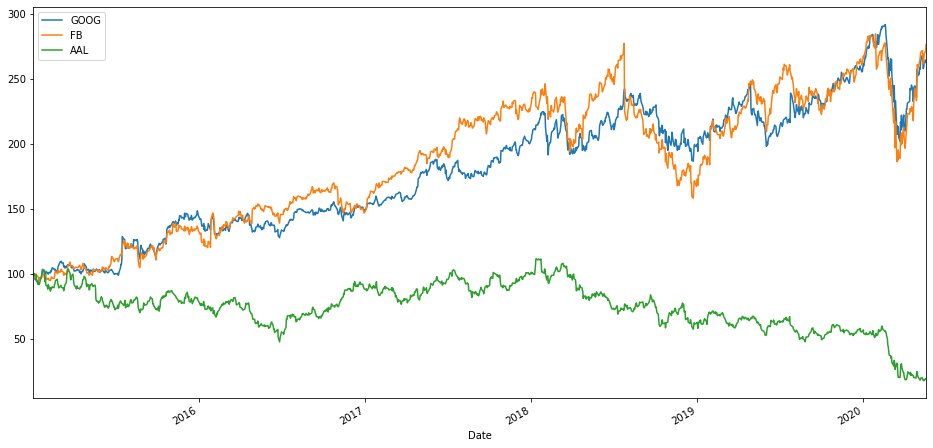

In [5]:
(import_stock_data(['GOOG','FB','AAL'], start = '2015-1-1')/import_stock_data(['GOOG','FB','AAL'], start = '2015-1-1').iloc[0]*100).plot(figsize=(16,8))

Wow! We include American Airlines (AAL) in the picture and it does not look very correlated - at least not as much as Google and Facebook. This is likely the case becasue Facebook and Google are both technology companies with most of their revenue streams coming from ads. Okay... back to the problems at hand!

Let's get the logarithmic returns of Google and Facebook.

In [31]:
def log_returns(data):
    return (np.log(1+data.pct_change()))

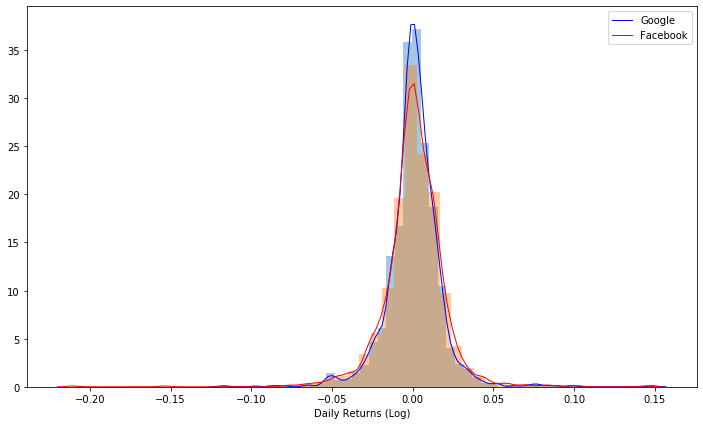

Google Average Daily Return:     0.0728%	 Google Yearly Average Return: 18.34%
Facebook Average Daily Return:     0.0798%	 Facebook Yearly Average Return: 20.12%


In [33]:
log_return = log_returns(data)
goog_ret = log_return['GOOG'][1:]
fb_ret = log_return['FB'][1:]

plt.figure(figsize=(12,7))
sns.distplot(goog_ret, kde_kws={"color":"b","lw":1,"label":"Google"})
sns.distplot(fb_ret, kde_kws={"color":"r","lw":1,"label":"Facebook"})
plt.xlabel("Daily Returns (Log)")
plt.show()
print(f"Google Average Daily Return: {round(goog_ret.mean()*100,4):{10}}%\t Google Yearly Average Return: {round(goog_ret.mean()*252*100,2)}%")
print(f"Facebook Average Daily Return: {round(fb_ret.mean()*100,4):{10}}%\t Facebook Yearly Average Return: {round(fb_ret.mean()*252*100,2)}%")

Great! The daily returns of stocks seem to be normally distributed but with long tails. A Cauchy distribution would fit best, or a fat-tailed distribution. To make things simple, we will approximate it with a normal distribution. 

Now, we begin modeling!

___

##### Brownian motion to estimate returns

Brownian motion will be the main driver for estimating the return. It is a stochastic process used for modeling random behavior over time. For simplicity, we will use regular brownian motion instead of the Geometric Brownian Motion.

**Brownian Motion** has two main main components:
1. Drift - the direction that rates of returns have had in the past. That is, the expected return of the stock.
$$
{Drift} = ({mean} - \frac{1}{2} {Var})
$$

    Why do we multiply the variance by 0.5? Because historical values are eroded in the future.
    

2. Volatility -  random variable. This is the historical volatility multiplied by a random, standard normally distributed variable.

$$
{Volatility} = {Std.Dev. * Z([Rand(0;1)])}
$$

Therefore, our asset pricing equation ends up looking like this:

$$
{Price Today}={Price Yesterday * e^{mean-\frac{1}{2}{Var} + Std.Dev * Z([Rand(0;1)])}}
$$



This technique will be used for every day into the future you want to predict, and for however many trials the monte carlo simulation will run!


First, we will calculate the drift 

In [34]:
def drift_calc(data, return_type='log'):
    if return_type=='log':
        lr = log_returns(data)
    elif return_type=='simple':
        lr = simple_returns(data)
    u = lr.mean()
    var = lr.var()
    drift = u-(0.5*var)
    try:
        return drift.values
    except:
        return drift

In [35]:
drift = drift_calc(data)
drift

array([0.00058642, 0.00060531])

In [36]:
stdev = log_returns(data).std().values

In [71]:
covari = log_return.cov()
covari

,GOOG,FB
GOOG,0.000282,0.000221
FB,0.000221,0.000386


Create Cholosky matrix from the covariance matrix.

In [72]:
chol = np.linalg.cholesky(covari)
chol

array([[0.01680492, 0.        ],
       [0.01317442, 0.01457171]])

    Let's define how many days we will forecast for and how many iterations we will do!

In [73]:
iterations = 1000
days = 252

Now, we must generate a series of uncorrelated random numbers. Since the array should be 3D (stocks, days, iterations) and it is complicated to deal with 3D arrays, we will cleverly use a 2D array that generates days x iterations standard normal random values and reshape it after we correlate them. This works because we do not care about the order.

In [74]:
uncorr_x = norm.ppf(np.random.rand(num_stocks,iterations*days)) #(stocks, iterations*days)
uncorr_x # Only showing the first 10 

array([[-1.09140567, -1.41640189, -0.08919201, ..., -2.08101673,
         1.05172515,  0.86270132],
       [ 0.56315361, -0.23681236,  1.15180386, ..., -0.06109878,
         0.70387323,  1.18763897]])

Finally! The part we've all been waiting for!

Now that we have the random standard normal values, we must correlate these according to the Cholosky method. This is easily done by taking the dot product of the cholesky decomposition matrix with the matrix of uncorrelated variables.

In [75]:
corr_x = np.dot(chol, uncorr_x)
corr_x

array([[-0.01834098, -0.02380252, -0.00149886, ..., -0.03497131,
         0.01767415,  0.01449762],
       [-0.00617253, -0.02211104,  0.0156087 , ..., -0.02830651,
         0.02411251,  0.02867152]])

Great! Now that we have generated correlated returns that represent the variance of the brownian motion derivation, we must calculate the daily returns for each stock by additing the drift of the stock and taking the exponent of the sum.

In [76]:
corr_2 = np.zeros_like(corr_x)
for i in range(num_stocks):
    corr_2[i] = np.exp(drift[i] + corr_x[i])
corr_2

array([[0.98240212, 0.97705133, 0.99908797, ..., 0.96619955, 1.01842832,
        1.01519838],
       [0.99444825, 0.97872387, 1.01634617, ..., 0.97267896, 1.02502584,
        1.02970961]])

Here it is! Now, for every stock, we will reshape the returns to create a matrix of days x iterations dimension. With it, we will multiply the return by the price of the previous day, starting at the last day in our real dataset... and voila! 

>-------------------------------     GOOG     --------------------------------<


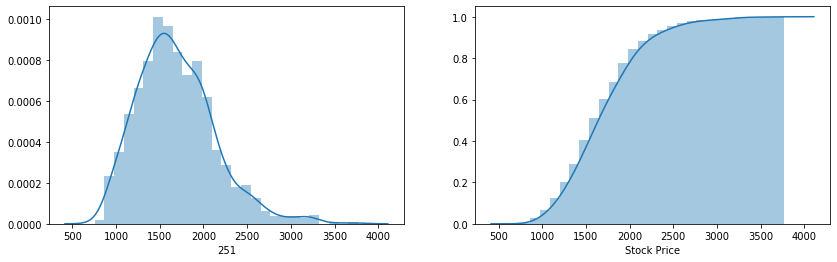

>-------------------------------     FB     --------------------------------<


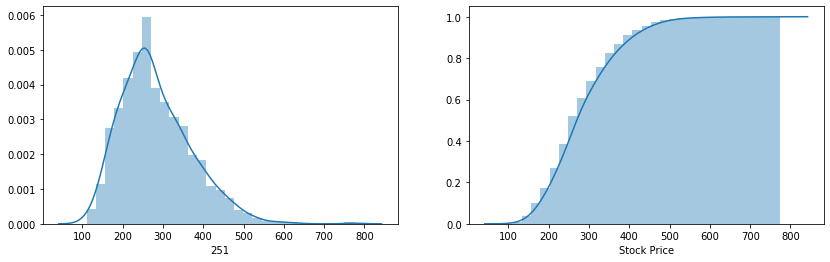

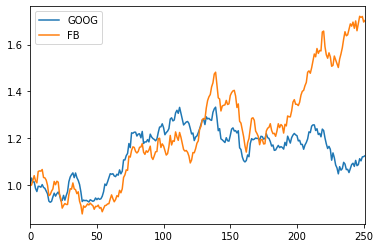

In [113]:
stock0 = pd.DataFrame()
for s in range(len(ticks)):
    ret_reshape = corr_2[s]
    ret_reshape = ret_reshape.reshape(days,iterations)
    price_list = np.zeros_like(ret_reshape)
    price_list[0] = data.iloc[-1,s]
    for t in range(1,days):
        price_list[t] = price_list[t-1]*ret_reshape[t]

    print(f">-------------------------------     {ticks[s]}     --------------------------------<")
    #y = pd.DataFrame(price_list).iloc[:,0:5].plot(figsize=(14,5))
    x = pd.DataFrame(price_list).iloc[-1]
    fig, ax = plt.subplots(1,2, figsize=(14,4))
    sns.distplot(x, ax=ax[0])
    sns.distplot(x, hist_kws={'cumulative':True},kde_kws={'cumulative':True},ax=ax[1])
    plt.xlabel("Stock Price")
    plt.show()
    x = pd.DataFrame(price_list)
    stock0[ticks[s]]=x.loc[:,0]
# Print Combo Plot
(stock0/stock0.iloc[0]).plot()

Text(0, 0.5, 'Normalized Prices')

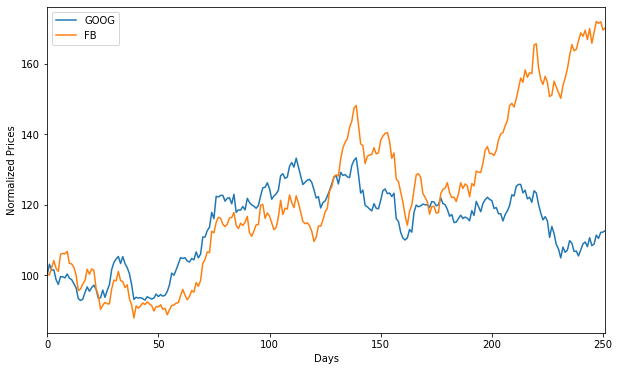

In [112]:
(stock0/stock0.iloc[0]*100).plot(figsize=(10,6))
plt.xlabel("Days")
plt.ylabel("Normalized Prices")

>-------------------------------     ['GOOG', 'FB']     --------------------------------<


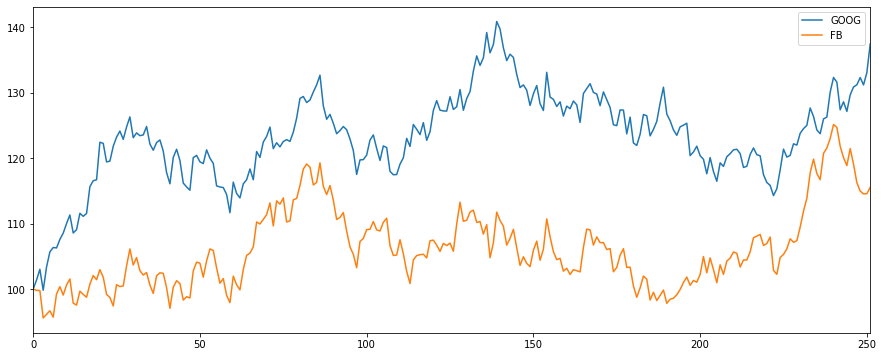

In [110]:
print(f">-------------------------------     {ticks}     --------------------------------<")
(pd.DataFrame(stockP0, index=['GOOG','FB']).T/pd.DataFrame(stockP0,index=['GOOG','FB']).T.iloc[0]*100).plot(figsize=(15,6))
plt.show()

**GREAT!** This concludes the Monte Carlo simulation using Cholesky Decomposition.

In [120]:
mrk_data = import_stock_data("^GSPC",'2015-1-1')
mrk_data.head()

,^GSPC
Date,
2015-01-02,2058.199951
2015-01-05,2020.579956
2015-01-06,2002.609985
2015-01-07,2025.900024
2015-01-08,2062.139893
...,...
2020-05-11,2930.189941
2020-05-12,2870.120117
2020-05-13,2820.000000


In [18]:
secondDF = pd.DataFrame(ret_reshape)
secondDF.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.973709,1.022418,1.003223,0.998610,0.996426,0.973124,0.990586,1.005099,0.988992,0.997571,...,0.994454,1.008663,1.013106,0.973149,1.018005,0.972862,1.034115,0.966101,1.008131,0.995963
1,1.031043,0.972062,0.997056,1.025998,0.987214,0.992492,1.023565,1.027660,0.992842,0.991751,...,1.022904,1.013611,1.005227,1.001385,1.007770,0.981420,1.027080,0.980400,1.004532,0.977563
2,0.978461,0.990483,0.982964,0.984920,1.016625,1.000989,1.022239,0.999948,1.019442,1.041794,...,0.977105,0.991269,0.985994,1.021626,0.981326,1.023232,1.033550,1.013431,0.971494,0.966011
3,1.032482,1.002581,0.969888,0.994153,1.002981,0.996509,1.026839,1.017974,0.996368,0.991349,...,1.016933,1.009203,0.999341,1.027793,0.989877,1.001625,1.006976,1.029570,0.956474,1.002689
4,0.976278,1.012208,0.980618,1.000258,0.983488,0.987961,0.988530,1.040751,1.011576,1.032215,...,0.980609,0.998932,1.022540,1.003874,1.016531,1.024909,0.984729,0.977066,0.980007,0.975535


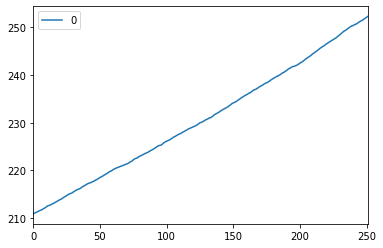

In [19]:
meanRets = secondDF.mean(axis=1)
secondList = np.zeros_like(meanRets)
secondList[0] = data.iloc[-1,1]
for t in range(1,days):
    secondList[t] = secondList[t-1]*meanRets[t]
pd.DataFrame(secondList).plot()

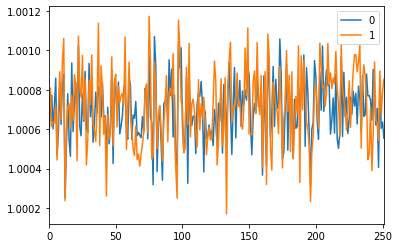

In [20]:
simRet = pd.DataFrame(avReturns).T
simRet.plot()

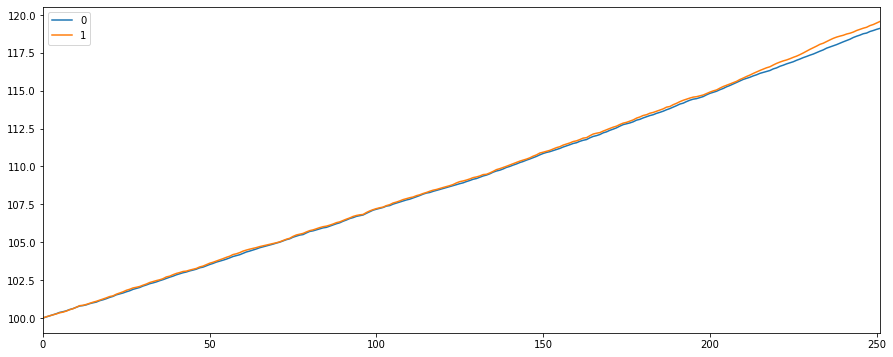

In [21]:
(pd.DataFrame(avPrices).T/pd.DataFrame(avPrices).T.iloc[0]*100).plot(figsize=(15,6))

In [22]:
simRet = simRet.rename(columns={0:'GOOG',1:'FB'})
simRet = simRet.to_numpy()
simPrice = np.zeros_like(simRet)
simPrice[0] = data.iloc[-1]
for t in range(1,days):
    simPrice[t] = simPrice[t-1]*simRet[t]
    

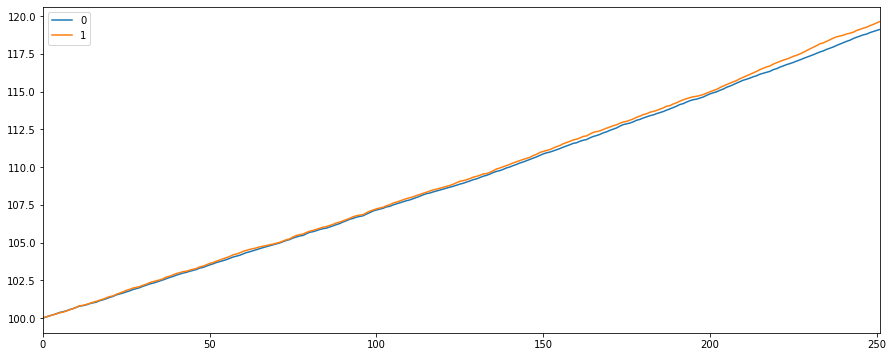

In [23]:
(pd.DataFrame(simPrice)/pd.DataFrame(simPrice).iloc[0]*100).plot(figsize=(15,6))

In [24]:
(pd.DataFrame(simRet).mean()-1)*252

0    0.175677
1    0.180174
dtype: float64

In [25]:
log_return.mean()*252

GOOG    0.179925
FB      0.184445
dtype: float64